In [16]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

seed=42

from fastai.vision.all import *

import PIL
import torchvision

from pathlib import Path
from zipfile import ZipFile

# import the requests library
import requests



import torch
import torch.nn as nn
import torch.nn.functional as F
if torch.cuda.is_available():
    print("Yeah we have a GPU!")
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


from fastai.vision import *

import pandas as pd
import plotly.express as px

from gdeep.decision_boundary.decision_boundary_calculator import *
from gdeep.create_nets.sample_nn import Net, CircleNN
from gdeep.create_nets.utility import ToFastaiNN, ToPyTorchNN, PeriodicNeuralNetworkMaker
from gdeep.plotting.plot_decision_bdry import plot_activation_contours
from gdeep.create_data.tori import make_torus_point_cloud, Rotation, make_torus_dataset
from gdeep.create_nets.utility import train_classification_nn
from gdeep.decision_boundary.compute_boundary import GradientFlow, UniformlySampledPoint
from gdeep.plotting import plot_decision_boundary

np.random.seed(seed)

In [6]:
# Download data set
path = untar_data(URLs.MNIST)


In [71]:
# Create data block (Dataset + DataLoader)
digits = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label
)
dls = digits.dataloaders(path)

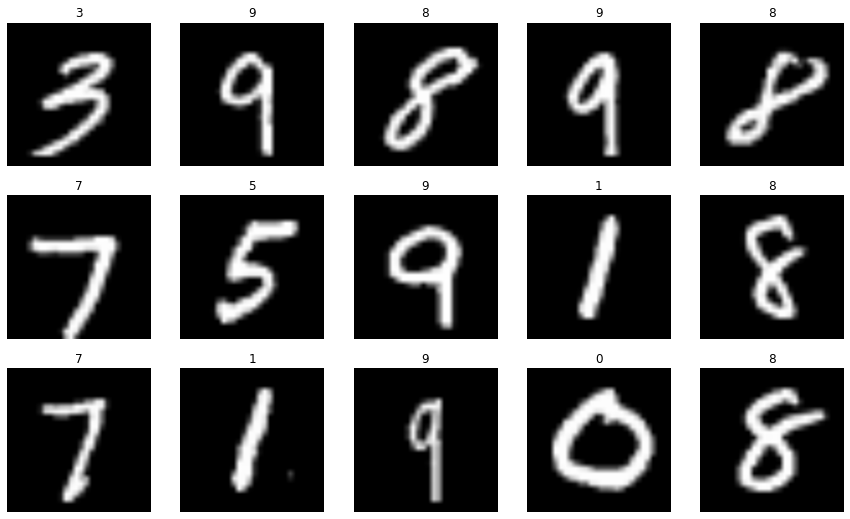

In [74]:
# Show sample digits
dls.valid.show_batch(max_n=15, nrows=3)

In [78]:
# Creat CNN Model
learn = cnn_learner(data, models.resnet18, metrics=accuracy, pretrained=True)
learn.fine_tune(1)

KeyboardInterrupt: 

In [ ]:
# Save model
learn.export()